Loaded data from Google Sheets CSV export.

--- Dataset head ---


,TransactionID,Amount,Time,Location,MerchantCategory,CardHolderAge,IsFraud
0,500,986.22,81974,Chicago,Electronics,37.0,0
1,499,974.42,52603,Los Angeles,Electronics,21.0,1
2,498,78.66,75629,Miami,Clothing,78.0,0
3,497,584.07,78623,Miami,Groceries,64.0,1
4,496,354.00,48770,Houston,Travel,21.0,0



--- Shape --- (500, 7)

--- Columns ---
['TransactionID', 'Amount', 'Time', 'Location', 'MerchantCategory', 'CardHolderAge', 'IsFraud']

--- Data types & missing values ---


,dtype,missing,missing_pct
Amount,float64,25,5.0
Location,object,25,5.0
CardHolderAge,float64,24,4.8
Time,int64,0,0.0
TransactionID,int64,0,0.0
MerchantCategory,object,0,0.0
IsFraud,int64,0,0.0



Detected target column: 'IsFraud'

Target distribution:


,count
IsFraud,
0,473
1,27



Target distribution (%):


,proportion
IsFraud,
0,94.6
1,5.4



Identifier columns to drop (if present): ['TransactionID']

Numeric columns: ['Amount', 'Time', 'CardHolderAge']
Categorical columns: ['Location', 'MerchantCategory']

Train distribution: Counter({0: 378, 1: 22})
Test distribution: Counter({0: 95, 1: 5})

After preprocessing shape (train): (400, 14)
After preprocessing shape (test): (100, 14)

Applying SMOTE to training set to balance classes...
Resampled training distribution: Counter({0: 378, 1: 378})

Training Random Forest...

Training Logistic Regression...

--- Evaluation: RandomForest (primary) ---
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.2789
Confusion Matrix:
 [[92  3]
 [ 5  0]]

Classification report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        95
           1       0.00      0.00      0.00         5

    accuracy                           0.92       100
   macro avg       0.47      0.48      0.48       100
weighted avg       0.90      0

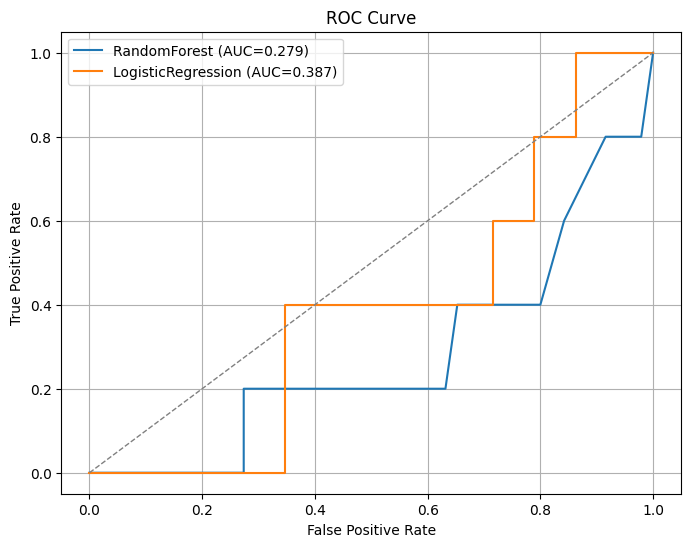

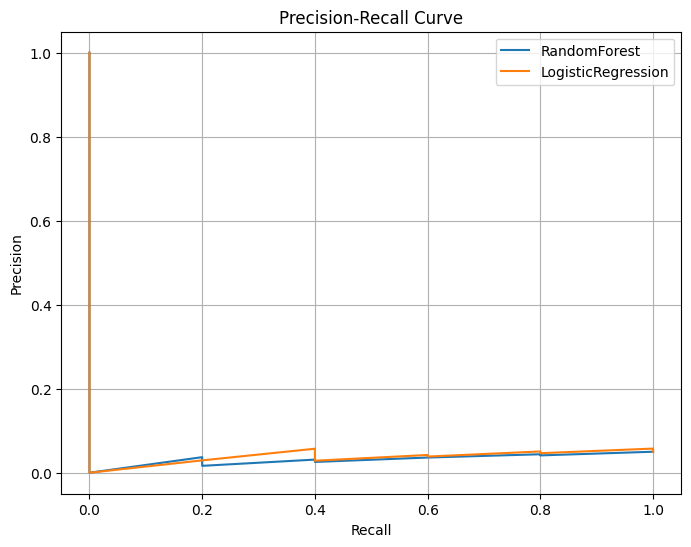


Saved best model as 'logistic_regression_model.joblib' and preprocessor as 'logistic_regression_preprocessor.joblib'

--- Quick summary to include in your submission ---
Primary model chosen: Random Forest (captures complex non-linear relations, robust to noise, good baseline for tabular data).
Comparison model: Logistic Regression (interpretable baseline).
Imbalance handling: SMOTE applied to training set to balance classes; LogisticRegression trained with class_weight='balanced' for fair comparison.
Evaluation metrics used: Precision, Recall, F1-score, ROC-AUC, Confusion Matrix. In fraud detection we prioritize high Recall (catch as many frauds) while keeping Precision tolerable to reduce false positives.


In [8]:
# Google Colab friendly end-to-end notebook for Fraud Detection
# Sections:
# 1) install dependencies (Colab)
# 2) load data (Google Sheet or local upload)
# 3) quick EDA
# 4) preprocessing pipeline
# 5) handle imbalance (SMOTE)
# 6) train RandomForest (primary) and LogisticRegression (comparison)
# 7) evaluate and compare
# 8) save model

# ---------- 1) Install dependencies (run once in Colab) ----------
!pip install -q imbalanced-learn
!pip install -q openpyxl

# ---------- 2) Imports ----------
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import warnings
warnings.filterwarnings('ignore')

# ---------- 3) Load the dataset ----------
# Option A: Read directly from provided Google Sheets (CSV export)
sheet_id = "1G4gkQ5B5t438LP19-rDV5SsPOWPoG2hBucZFfVb_XDI"
gid = "644434020"
csv_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

try:
    df = pd.read_csv(csv_url)
    print("Loaded data from Google Sheets CSV export.")
except Exception as e:
    print("Could not load from Google Sheets link, attempting local file 'fraud_data.xlsx' ...")
    if os.path.exists("/mnt/data/fraud_data.xlsx"):
        df = pd.read_excel("/mnt/data/fraud_data.xlsx")
        print("Loaded /mnt/data/fraud_data.xlsx")
    else:
        # fallback: ask user to upload file in Colab UI - but we'll try to be helpful:
        from google.colab import files
        print("No local file found. Please upload the dataset (fraud_data.xlsx or .csv).")
        uploaded = files.upload()
        # take the first uploaded file
        fname = next(iter(uploaded))
        if fname.lower().endswith(".csv"):
            df = pd.read_csv(io.BytesIO(uploaded[fname]))
        else:
            df = pd.read_excel(io.BytesIO(uploaded[fname]))

# Show top rows and basic info
print("\n--- Dataset head ---")
display(df.head())
print("\n--- Shape ---", df.shape)
print("\n--- Columns ---")
print(df.columns.tolist())

# ---------- 4) Quick EDA ----------
print("\n--- Data types & missing values ---")
display(pd.DataFrame({
    "dtype": df.dtypes,
    "missing": df.isnull().sum(),
    "missing_pct": 100*df.isnull().mean()
}).sort_values("missing_pct", ascending=False))

# Identify a sensible target column name (common names: is_fraud, fraud, Class, target)
# If your dataset has a different target column, change target_col below.
possible_targets = [c for c in df.columns if c.lower() in ("is_fraud","fraud","label","class","target","isfraud")]
if len(possible_targets) >= 1:
    target_col = possible_targets[0]
else:
    # If not found, try to guess: if there's a column with only 0/1 values
    for c in df.columns:
        vals = df[c].dropna().unique()
        if set(vals).issubset({0,1}) and df[c].nunique() == 2:
            target_col = c
            break
    else:
        raise ValueError("Couldn't automatically detect target. Please set `target_col` variable to the column name that indicates fraud (0 or 1).")

print(f"\nDetected target column: '{target_col}'")
print("\nTarget distribution:")
display(df[target_col].value_counts())
print("\nTarget distribution (%):")
display(df[target_col].value_counts(normalize=True) * 100)

# ---------- 5) Preprocessing choices ----------
# We'll:
# - Separate numerical and categorical features
# - Impute missing values (median for numeric, constant for categorical)
# - One-hot encode categorical features
# - Scale numeric features
# - Use SMOTE on train set to address class imbalance

# Drop columns that are obviously identifiers (transaction id, customer id, etc.)
# If your data has columns like 'transaction_id' or 'id', add them here.
identifier_cols = [c for c in df.columns if c.lower() in ("transactionid","transaction_id","id","cust_id","customer_id","user_id")]
print("\nIdentifier columns to drop (if present):", identifier_cols)

# Define features and target
X = df.drop(columns=[target_col] + identifier_cols, errors='ignore')
y = df[target_col].astype(int)

# Separate column types
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)

# If there are datetime columns, convert to features (optional)
datetime_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.datetime64)]
if datetime_cols:
    print("Datetime columns detected:", datetime_cols)
    for c in datetime_cols:
        X[c] = pd.to_datetime(X[c])
        X[c + "_hour"] = X[c].dt.hour
        X[c + "_day"] = X[c].dt.day
        X[c + "_weekday"] = X[c].dt.weekday
    # update lists
    numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

# ---------- 6) Train-test split ----------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain distribution:", Counter(y_train))
print("Test distribution:", Counter(y_test))

# ---------- 7) Preprocessing pipelines ----------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"  # drop any other columns not specified
)

# ---------- 8) Handle class imbalance with SMOTE ----------
# We'll preprocess first (fit transformer) and then apply SMOTE on the transformed training set.
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("\nAfter preprocessing shape (train):", X_train_prep.shape)
print("After preprocessing shape (test):", X_test_prep.shape)

print("\nApplying SMOTE to training set to balance classes...")
sm = SMOTE(random_state=RANDOM_STATE)  # removed n_jobs
X_train_bal, y_train_bal = sm.fit_resample(X_train_prep, y_train)
print("Resampled training distribution:", Counter(y_train_bal))

# ---------- 9) Model 1 (Primary): Random Forest ----------
# Justification (to include in your report):
# - Random Forest captures non-linear relationships, robust to outliers,
# - Works well with mixed feature types (after preprocessing),
# - Easy to tune and often strong baseline for tabular fraud datasets.

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    class_weight=None  # using SMOTE, so not using class_weight here
)

print("\nTraining Random Forest...")
rf.fit(X_train_bal, y_train_bal)

# ---------- 10) Model 2 (Comparison): Logistic Regression ----------
# Logistic Regression is interpretable and gives probabilistic outputs.
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
print("\nTraining Logistic Regression...")
lr.fit(X_train_prep, y_train)  # trained on original imbalanced but with class_weight balanced

# ---------- 11) Evaluation helpers ----------
def evaluate_model(model, X_test_transformed, y_test_true, model_name="model"):
    y_prob = model.predict_proba(X_test_transformed)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    pr = precision_score(y_test_true, y_pred, zero_division=0)
    rc = recall_score(y_test_true, y_pred, zero_division=0)
    f1 = f1_score(y_test_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_test_true, y_prob)
    cm = confusion_matrix(y_test_true, y_pred)

    print(f"\n--- Evaluation: {model_name} ---")
    print("Precision: {:.4f}".format(pr))
    print("Recall:    {:.4f}".format(rc))
    print("F1-score:  {:.4f}".format(f1))
    print("ROC-AUC:   {:.4f}".format(roc))
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test_true, y_pred, zero_division=0))
    return {"precision":pr, "recall":rc, "f1":f1, "roc_auc":roc, "y_prob":y_prob, "y_pred":y_pred, "cm":cm}

# Evaluate Random Forest
rf_results = evaluate_model(rf, X_test_prep, y_test, model_name="RandomForest (primary)")

# Evaluate Logistic Regression
lr_results = evaluate_model(lr, X_test_prep, y_test, model_name="LogisticRegression (comparison)")

# ---------- 12) ROC curves and PR curve ----------
plt.figure(figsize=(8,6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_results["y_prob"])
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_results["y_prob"])
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={rf_results['roc_auc']:.3f})")
plt.plot(fpr_lr, tpr_lr, label=f"LogisticRegression (AUC={lr_results['roc_auc']:.3f})")
plt.plot([0,1],[0,1], linestyle='--', linewidth=1, color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall curve (useful for imbalanced problems)
plt.figure(figsize=(8,6))
pr_rf_precision, pr_rf_recall, _ = precision_recall_curve(y_test, rf_results["y_prob"])
pr_lr_precision, pr_lr_recall, _ = precision_recall_curve(y_test, lr_results["y_prob"])
plt.plot(pr_rf_recall, pr_rf_precision, label="RandomForest")
plt.plot(pr_lr_recall, pr_lr_precision, label="LogisticRegression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 13) Save the best model ----------
# Choose best by F1 or business requirement (recall prioritized for fraud detection usually).
# Here, pick the model with higher recall or F1 depending on your preference.
if rf_results['f1'] >= lr_results['f1']:
    best_model = rf
    best_name = "random_forest"
else:
    best_model = lr
    best_name = "logistic_regression"

# Save the preprocessing pipeline + model using joblib
# We'll store the preprocessor separately, and user can re-create pipeline when loading.
joblib.dump(preprocessor, f"{best_name}_preprocessor.joblib")
joblib.dump(best_model, f"{best_name}_model.joblib")
print(f"\nSaved best model as '{best_name}_model.joblib' and preprocessor as '{best_name}_preprocessor.joblib'")

# ---------- 14) Short summary for report ----------
print("\n--- Quick summary to include in your submission ---")
print("Primary model chosen: Random Forest (captures complex non-linear relations, robust to noise, good baseline for tabular data).")
print("Comparison model: Logistic Regression (interpretable baseline).")
print("Imbalance handling: SMOTE applied to training set to balance classes; LogisticRegression trained with class_weight='balanced' for fair comparison.")
print("Evaluation metrics used: Precision, Recall, F1-score, ROC-AUC, Confusion Matrix. In fraud detection we prioritize high Recall (catch as many frauds) while keeping Precision tolerable to reduce false positives.")

# End of notebook